In [1]:
%matplotlib inline
from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaBase import TICK_DB_NAME
from datetime import datetime, time
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarManager, 
                                                     ArrayManager)

In [2]:
'''
我的策略
'''
class SimpleStrategy(CtaTemplate):
    """根据夜盘收盘前的价格趋势开仓入场，移动百分比离场"""
    className = 'SimpleStrategy'
    author = u'loe'

    # 策略参数
    tradeSize = 1 # 交易数量
    startTime = time(22, 58, 26) # 趋势判断开始时间
    endTime =  time(22, 59, 56) # 趋势判断截至时间
    outPercent = 0.1 # 移动止盈止损百分比

    # 策略变量
    todayDate = None # 当前日期
    todayEntry = False # 当天是否已经产生信号
    startPrice = EMPTY_FLOAT # 趋势判断开始价格
    endPrice = EMPTY_FLOAT # 趋势判断截至价格
    highPrice = EMPTY_FLOAT # 持仓后的最高价，为了多头止盈止损的计算
    lowPrice = EMPTY_FLOAT # 持仓后的最低价， 为了空头止盈止损的计算

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'tradeSize',
                 'startTime',
                 'endTime',
                 'outPercent']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'todayDate',
               'todayEntry',
               'startPrice',
               'endPrice',
               'highPrice',
               'lowPrice']
    
    # 同步列表
    syncList = ['pos',
                'highPrice',
                'lowPrice']
    
    #测试------
    entryPrice = EMPTY_FLOAT
    outPrice = EMPTY_FLOAT
    totalEarning = EMPTY_FLOAT
    

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(SimpleStrategy, self).__init__(ctaEngine, setting)        

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        #'''
        if (tick.datetime.time() >= self.endTime) or (tick.datetime.time() <= time(9, 0, 20)):
            print tick.datetime, ' '*2, tick.lastPrice, ' '*2, 'ask:', tick.askPrice1, 'bid:', tick.bidPrice1
        #'''
        
        #撤销未成交的单
        self.cancelAll()
        
        if (not self.todayDate) or (self.todayDate != tick.datetime.date()):
            # 早盘第一个tick收到后信号初始化
            #print tick.datetime, '='*16
            self.todayDate = tick.datetime.date()
            self.todayEntry = False
            self.startPrice = EMPTY_FLOAT
            self.endPrice = EMPTY_FLOAT
        
        if self.pos == 0:
            self.highPrice = EMPTY_FLOAT
            self.lowPrice = EMPTY_FLOAT
            # 当前仓位为空才会做新的开仓信号判断
            if (self.startPrice == 0) and (tick.datetime.time() >= self.startTime) and (tick.datetime.time() < self.endTime):
                self.startPrice = tick.lastPrice
            
            if (self.endPrice == 0) and (tick.datetime.time() >= self.endTime):
                self.endPrice = tick.lastPrice
            
            if self.startPrice and self.endPrice and (not self.todayEntry):
                sub = self.endPrice - self.startPrice
                if sub > 0:
                    # 开仓多头
                    self.buy(tick.lastPrice + 10, self.tradeSize) # 限价单
                    print u'委托多头开仓', tick.datetime, '*'*2, tick.lastPrice

                elif sub < 0:
                    # 开仓空头
                    self.short(tick.lastPrice - 10, self.tradeSize) # 限价单
                    print u'委托空头开仓', tick.datetime, '*'*2, tick.lastPrice
        elif self.pos > 0:
            # 持有多头仓位
            '''
            print '='*20, tick.datetime, '='*20
            print 'tickPrice', '*'*2, tick.lastPrice
            print 'highPrice', '*'*2, self.highPrice
            '''
            if tick.lastPrice <= self.highPrice * (1 - self.outPercent/100):
                #止盈止损
                self.sell(tick.lastPrice -10, abs(self.pos)) # 限价单
                print u'委托平仓', tick.datetime, '*'*2, tick.lastPrice
                #print u'止损'
        elif self.pos < 0:
            # 持有空头仓位
            '''
            print '='*20, tick.datetime, '='*20
            print 'tickPrice', '*'*2, tick.lastPrice
            print 'lowPrice', '*'*2, self.lowPrice
            '''
            if tick.lastPrice >= self.lowPrice * (1 + self.outPercent/100):
                #止盈止损
                self.cover(tick.lastPrice +10, abs(self.pos)) # 限价单
                print u'委托平仓', tick.datetime, '*'*2, tick.lastPrice
                #print u'止损'
                
        if self.pos:
            self.highPrice = max(self.highPrice, tick.lastPrice)
            self.lowPrice = min(self.lowPrice, tick.lastPrice)

        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        self.putEvent()
        if trade.offset == u'开仓':
            self.todayEntry = True
            self.highPrice = trade.price
            self.lowPrice = trade.price
        '''
        print '#'*20, 'T R A D E', '#'*20
        print trade.tradeTime
        print trade.direction
        print trade.offset
        print trade.price
        print self.pos, '\n'
        '''
        
        #测试------
        if trade.offset == u'开仓':
            self.entryPrice = trade.price
            #print u'开仓时间======', self.todayDate.strftime('%Y-%m-%d') + ' ' + trade.tradeTime
        elif trade.offset == u'平仓':
            self.outPrice = trade.price
            #'''
            print u'平仓时间======', self.todayDate.strftime('%Y-%m-%d') + ' ' + trade.tradeTime
            print u'开仓价======', self.entryPrice
            print u'平仓价======', self.outPrice
            #'''
            sub = self.outPrice - self.entryPrice
            if trade.direction == u'多':
                self.totalEarning -= sub
                '''
                print u'空'
                print '='*6, u'盈亏 ', -sub, '='*6
                print '='*6, u'累计盈亏 ', self.totalEarning, '='*6
                '''
            else:
                self.totalEarning += sub
                '''
                print u'多'
                print '='*6, u'盈亏 ', sub, '='*6
                print '='*6, u'累计盈亏 ', self.totalEarning, '='*6
                '''
            
            print '\n'
            

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
def runBacktesting(strategyClass, settingDict, symbol, 
                   startDate, endDate, slippage, 
                   rate, size, priceTick):
    """运行单标的回测"""
    #创建回测引擎实例
    engine = BacktestingEngine()
    
    #设置引擎的回测模式为K线
    engine.setBacktestingMode(engine.TICK_MODE)
    
    #设置使用的数据库
    engine.setDatabase(TICK_DB_NAME, symbol)

    #设置回测的起始日期
    engine.setStartDate(startDate, initDays = 0)
    
    #设置回测的截至日期
    engine.setEndDate(endDate)
    
    #滑点设置
    engine.setSlippage(slippage)
    
    #合约交易手续费
    engine.setRate(rate)   
    
    #合约每手数量
    engine.setSize(size)
    
    #合约最小价格变动
    engine.setPriceTick(priceTick)
    
    #引擎中创建策略对象
    engine.initStrategy(strategyClass, settingDict)
    
    #开始回测
    engine.runBacktesting()
    
    df = engine.calculateDailyResult()
    return df

In [10]:
df1 = runBacktesting(SimpleStrategy, {}, 'rb00.TB', 
                     '20170102', '20171230', 0, 
                     2.5/10000, 10, 1)
df1

2018-01-29 08:59:42.544000	开始载入数据
2018-01-29 08:59:53.870000	载入完成，数据量：10003669
2018-01-29 08:59:53.870000	开始回测
2018-01-29 08:59:53.870000	策略初始化完成
2018-01-29 08:59:53.871000	策略启动完成
2018-01-29 08:59:53.872000	开始回放数据
2017-01-03 09:00:00.500000    2889.0    ask: 2888.0 bid: 2886.0
2017-01-03 09:00:01    2889.0    ask: 2888.0 bid: 2885.0
2017-01-03 09:00:01.500000    2889.0    ask: 2889.0 bid: 2886.0
2017-01-03 09:00:02    2886.0    ask: 2886.0 bid: 2882.0
2017-01-03 09:00:02.500000    2885.0    ask: 2885.0 bid: 2883.0
2017-01-03 09:00:03    2883.0    ask: 2883.0 bid: 2882.0
2017-01-03 09:00:03.500000    2882.0    ask: 2882.0 bid: 2881.0
2017-01-03 09:00:04    2881.0    ask: 2883.0 bid: 2882.0
2017-01-03 09:00:04.500000    2883.0    ask: 2885.0 bid: 2883.0
2017-01-03 09:00:05    2883.0    ask: 2885.0 bid: 2883.0
2017-01-03 09:00:05.500000    2883.0    ask: 2884.0 bid: 2883.0
2017-01-03 09:00:06    2885.0    ask: 2886.0 bid: 2885.0
2017-01-03 09:00:06.500000    2883.0    ask: 2885.0 bid: 288

,closePosition,closePrice,commission,netPnl,openPosition,positionPnl,previousClose,slippage,totalPnl,tradeCount,tradeList,tradingPnl,turnover
date,,,,,,,,,,,,,
2017-01-03,1,2867.0,7.1700,-17.1700,0,0.0,0.0,0,-10.0,1,[<vnpy.trader.vtObject.VtTradeData object at 0...,-10.0,28680.0
2017-01-04,0,2935.0,21.8375,-81.8375,1,680.0,2867.0,0,-60.0,3,[<vnpy.trader.vtObject.VtTradeData object at 0...,-740.0,87350.0
2017-01-05,0,2957.0,0.0000,0.0000,0,0.0,2935.0,0,0.0,0,[],0.0,0.0
2017-01-06,0,2910.0,14.5625,-24.5625,0,-0.0,2957.0,0,-10.0,2,[<vnpy.trader.vtObject.VtTradeData object at 0...,-10.0,58250.0
2017-01-09,0,3072.0,0.0000,0.0000,0,0.0,2910.0,0,0.0,0,[],0.0,0.0
2017-01-10,0,3194.0,0.0000,0.0000,0,0.0,3072.0,0,0.0,0,[],0.0,0.0
2017-01-11,1,3230.0,8.0800,-28.0800,0,0.0,3194.0,0,-20.0,1,[<vnpy.trader.vtObject.VtTradeData object at 0...,-20.0,32320.0
2017-01-12,0,3228.0,8.0450,-128.0450,1,-20.0,3230.0,0,-120.0,1,[<vnpy.trader.vtObject.VtTradeData object at 0...,-100.0,32180.0
2017-01-13,1,3239.0,8.0950,1.9050,0,0.0,3228.0,0,10.0,1,[<vnpy.trader.vtObject.VtTradeData object at 0...,10.0,32380.0


In [8]:
df2 = runBacktesting(SimpleStrategy, {}, 'rb1705.TB', 
                     '20170101', '20170106', 0, 
                     1/10000, 10, 1)

2018-01-28 16:21:51.545000	开始载入数据
2018-01-28 16:21:52.225000	载入完成，数据量：165452
2018-01-28 16:21:52.226000	开始回测
2018-01-28 16:21:52.226000	策略初始化完成
2018-01-28 16:21:52.226000	策略启动完成
2018-01-28 16:21:52.226000	开始回放数据
2018-01-28 16:22:19.494000	数据回放结束
2018-01-28 16:22:19.495000	计算按日统计结果


2018-01-29 11:32:08.380000	------------------------------
2018-01-29 11:32:08.380000	首个交易日：	2017-01-03
2018-01-29 11:32:08.380000	最后交易日：	2017-12-29
2018-01-29 11:32:08.380000	总交易日：	244
2018-01-29 11:32:08.381000	盈利交易日	93
2018-01-29 11:32:08.381000	亏损交易日：	146
2018-01-29 11:32:08.381000	起始资金：	8000
2018-01-29 11:32:08.381000	结束资金：	8,956.54
2018-01-29 11:32:08.381000	总收益率：	11.96
2018-01-29 11:32:08.381000	总盈亏：	956.54
2018-01-29 11:32:08.381000	最大回撤: 	-1,899.43
2018-01-29 11:32:08.381000	总手续费：	3,843.46
2018-01-29 11:32:08.381000	总滑点：	0.0
2018-01-29 11:32:08.381000	总成交金额：	15,373,840.0
2018-01-29 11:32:08.381000	总成交笔数：	440.0
2018-01-29 11:32:08.381000	日均盈亏：	3.92
2018-01-29 11:32:08.381000	日均手续费：	15.75
2018-01-29 11:32:08.381000	日均滑点：	0.0
2018-01-29 11:32:08.381000	日均成交金额：	63,007.54
2018-01-29 11:32:08.381000	日均成交笔数：	1.8
2018-01-29 11:32:08.381000	日均收益率：	0.05%
2018-01-29 11:32:08.381000	收益标准差：	1.78%
2018-01-29 11:32:08.381000	Sharpe Ratio：	0.41


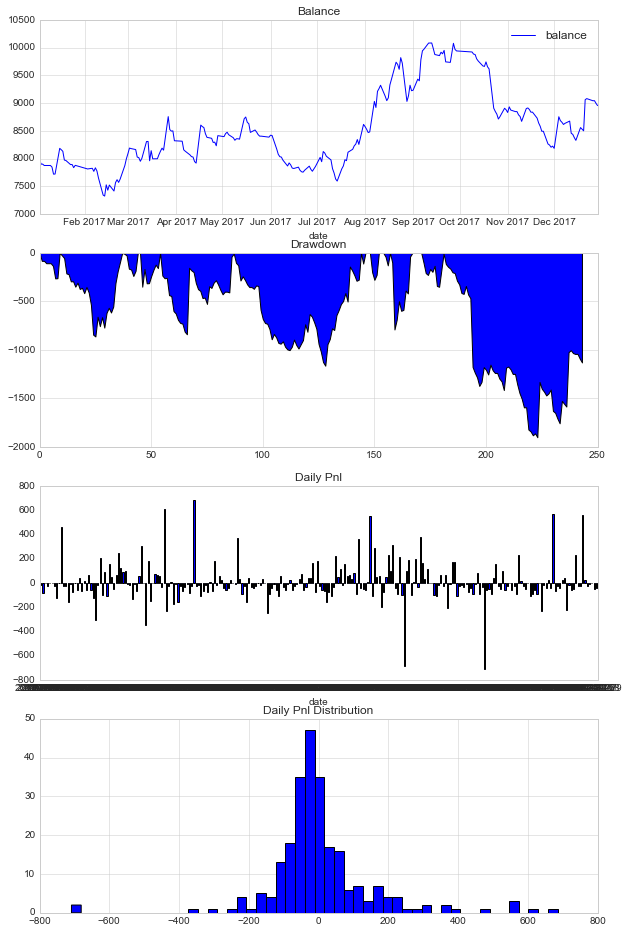

In [14]:
# 合并获得组合回测结果
#dfp = df1 + df2
dfp =  df1

# 注意如果被抛弃的交易日位于回测的前后，即两者不重合的日期中，则不会影响组合曲线正确性
# 但是如果被抛弃的交易日位于回测的中部，即两者重合的日期中，组合曲线会出现错误（丢失交易日）
dfp = dfp.dropna() 

# 创建回测引擎，并设置组合回测初始资金后，显示结果
engine = BacktestingEngine()
engine.setCapital(8000)
dfp, result = engine.calculateDailyStatistics(dfp)
engine.showDailyResult(dfp, result)


2018-01-15 18:01:00.183000	开始载入数据
2018-01-15 18:01:07.294000	载入完成，数据量：3510934
2018-01-15 18:01:07.294000	开始回测
2018-01-15 18:01:07.294000	策略初始化完成
2018-01-15 18:01:07.294000	策略启动完成
2018-01-15 18:01:07.295000	开始回放数据
2018-01-15 18:06:34.464000	数据回放结束
2018-01-15 18:06:34.465000	计算按日统计结果
2018-01-15 18:06:35.167000	------------------------------
2018-01-15 18:06:35.167000	首个交易日：	2017-08-02
2018-01-15 18:06:35.167000	最后交易日：	2018-01-12
2018-01-15 18:06:35.168000	总交易日：	131
2018-01-15 18:06:35.168000	盈利交易日	43
2018-01-15 18:06:35.168000	亏损交易日：	78
2018-01-15 18:06:35.168000	起始资金：	6000
2018-01-15 18:06:35.168000	结束资金：	8,276.12
2018-01-15 18:06:35.168000	总收益率：	37.94
2018-01-15 18:06:35.168000	总盈亏：	2,276.12
2018-01-15 18:06:35.168000	最大回撤: 	-1,478.31
2018-01-15 18:06:35.168000	总手续费：	703.88
2018-01-15 18:06:35.168000	总滑点：	1,880.0
2018-01-15 18:06:35.168000	总成交金额：	7,038,840.0
2018-01-15 18:06:35.168000	总成交笔数：	188.0
2018-01-15 18:06:35.168000	日均盈亏：	17.37
2018-01-15 18:06:35.168000	日均手续费：	5.37
2018-01-15 

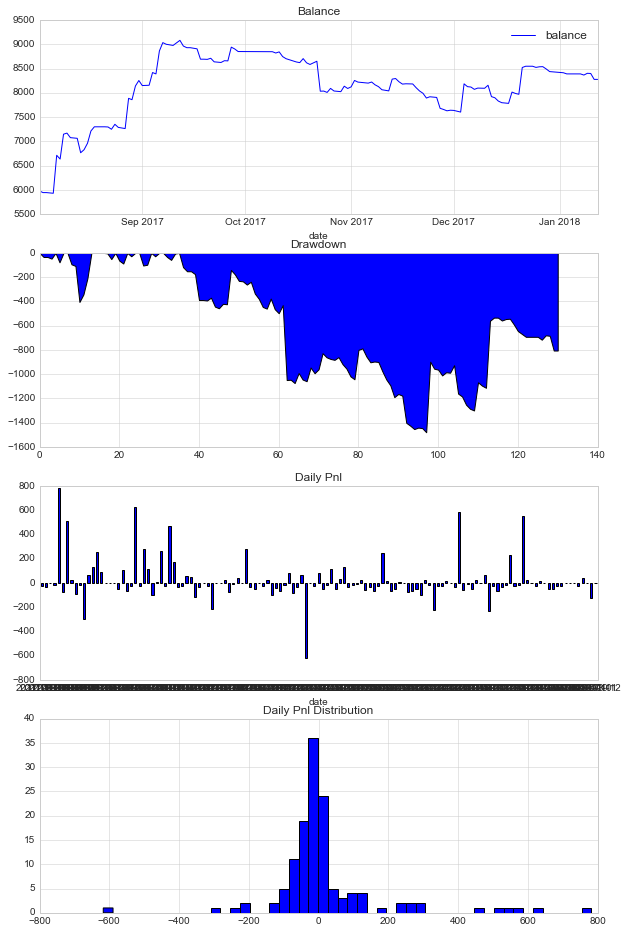

In [33]:
'''
回测
'''

#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线
engine.setBacktestingMode(engine.TICK_MODE)

#设置回测的起始日期
engine.setStartDate(startDate, initDays = 0)

#设置产品相关参数
engine.setSlippage(1)           #滑点设置
engine.setRate(1.0/10000)       #合约交易手续费万1
engine.setSize(10)               #合约每手数量
engine.setPriceTick(1)      #合约最小价格变动
engine.setCapital(6000) #初始资金

#设置使用的数据库
engine.setDatabase(TICK_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(SimpleStrategy, {})

#开始回测 
engine.runBacktesting()

#显示回测结果
engine.showDailyResult()

In [15]:
print u'用时 %ld' % 1

用时 1
